In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette('Set1'))

In [2]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12,'axes.titlesize':14,'axes.labelsize':13,'xtick.labelsize':12,\
                    'ytick.labelsize':12,'legend.fontsize':12,'legend.title_fontsize':12})

In [3]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [7]:
df = MIC_ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [8]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [9]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [10]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size=0.2)

In [12]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

forest = RandomForestClassifier(n_jobs=-1, random_state=0)
param_grid = {'n_estimators':[10,20,30,40,50,60,100],
              'max_depth':[1,2,4,6,8,10], 'max_features': ['auto', 'sqrt'], \
             'min_samples_leaf': [1, 2, 4]}

In [13]:
# accuracy

In [14]:
#grid search with shuffled kfold validation
KFold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=KFold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.770766129032258
grid_kfold_shuffle: test set average accuracy:  0.725 



In [15]:
# precision

In [16]:
#grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=10, n_estimators=40, n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7494106048595913
grid_kfold_shuffle test set average precision:  0.6684576485892275 



In [17]:
# AUC

In [18]:
#grid search with shuffled kfold validation
#use predict_prob a function ot calculate ROC AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(forest, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 RandomForestClassifier(max_depth=4, min_samples_leaf=2, n_estimators=40,
                       n_jobs=-1, random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.7744485545414338
grid_kfold_shuffle test set AUC:  0.7173333333333334 



In [19]:

#best parameters for AUC

from sklearn.metrics import confusion_matrix

forest = RandomForestClassifier(max_depth=4, min_samples_leaf=2, n_estimators=40,
                       n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predict = forest.predict(X_test_nodup).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

#calculate precision, sensitivity, specficity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

# begins creates list for model comparison:
direct_VME = very_major_error
direct_ME = major_error

Precision:  0.7142857142857143
Sensitivity:  0.6451612903225806
Specificity:  0.8181818181818182
FPR : 0.18181818181818177
very major error : 18.181818181818183
major error:  35.483870967741936

 confusion matrix: 
 [[36  8]
 [11 20]]


{0: 47, 1: 28}


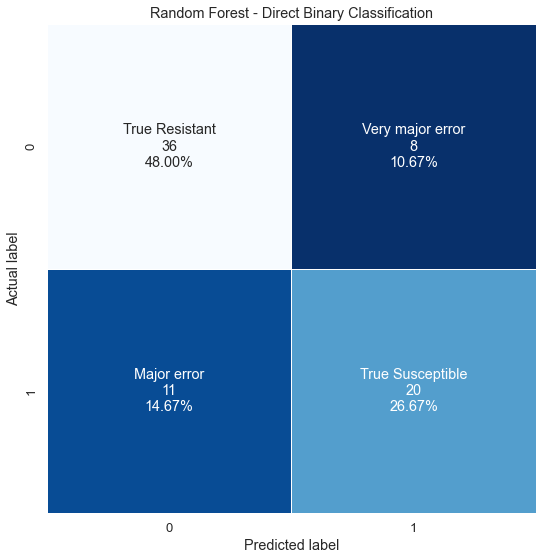

In [20]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
sns.set(font_scale=1.2)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Random Forest - Direct Binary Classification on MIC data');
#plt.savefig('figures/unshifted_direct_matrix_MIC_RF.png')

C:\Users\user\AppData\Local\Temp/ipykernel_28704/3792559395.py:29: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_28704/3792559395.py:29: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_28704/3792559395.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_28704/3792559395.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))


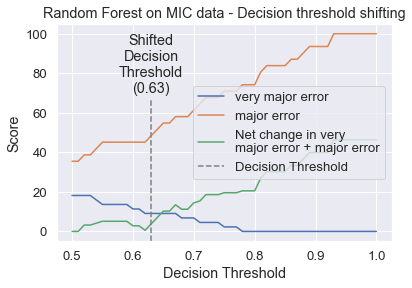

Optimum threshold to reduce very major error without     increasing major error by more than 1.5x :
 0.63


In [23]:
# graph showing how major and very major error changes with decision threshold

threshold  = np.linspace(0.5,1,num = 51)
very_major_error = []
major_error = []
net_error_change = []
threshold_shift = []

forest = RandomForestClassifier(max_depth=4, min_samples_leaf=2, n_estimators=40,
                       n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predicted_proba = forest.predict_proba(X_test_nodup)

predict = (predicted_proba[:,1] >= 0.5).astype('int')
confusion = confusion_matrix(y_test_nodup, predict)
og_very_major_error = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
og_major_error = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

for i in threshold:
    predict = (predicted_proba[:,1] >= i).astype('int')
    confusion = confusion_matrix(y_test_nodup, predict)
    very_major_error.append((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
    major_error.append((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

    #code to mathematically determine optimum threshold shifting
    vm_error_cost = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100) - og_very_major_error
    m_error_cost = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100) - og_major_error
    net_error_change.append(m_error_cost + vm_error_cost)
    grad_change = (m_error_cost / (-1*vm_error_cost))
    if grad_change <= 1.5:
        threshold_shift.append(i)
    
    
    
plt.plot(threshold, very_major_error, label = 'very major error')
plt.plot(threshold, major_error, label = 'major error')
plt.plot(threshold, net_error_change, label = 'Net change in very\nmajor error + major error')
plt.axvline(x=0.63, ymax=0.65, color ='grey', label = 'Decision Threshold', linestyle ='--')
plt.text(0.63,70,'Shifted\nDecision\nThreshold\n(0.63)', horizontalalignment = 'center')
plt.ylabel('Score')
plt.xlabel('Decision Threshold')
plt.legend(loc = 'right')
plt.title('Random Forest on MIC data - Decision threshold shifting')
#plt.savefig('figures/decision_curve_MIC_RF.png')
plt.show()

if threshold_shift == []:
    optimum_thresh = 0.5
    print('Shifting does not improve results')
else:
    optimum_thresh = max(threshold_shift)
    print('Optimum threshold to reduce very major error without \
    increasing major error by more than 1.5x :\n'\
        ,max(threshold_shift))

In [24]:
# shift threshold accoriding to data above - optimum theshold to decrease FPR without
# increasing major error by more than 1.5 x
# = ~0.63


# NOTE - shift actually makes the model worse here, there is no change in FPR and a slight increase
# in major error

forest = RandomForestClassifier(max_depth=4, min_samples_leaf=2, n_estimators=40,
                       n_jobs=-1, random_state=0)
forest.fit(X_train_cv, y_train_cv)
predicted_proba = forest.predict_proba(X_test_nodup)
predict = (predicted_proba[:,1] >= optimum_thresh).astype('int')
confusion = confusion_matrix(y_test_nodup, predict)

Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)

print ('\n confusion_matrix: \n', confusion)

# adds to list for model quality comparison
shifted_direct_VME = very_major_error
shifted_direct_ME = major_error

Precision:  0.8
Sensitivity:  0.5161290322580645
Specificity:  0.9090909090909091
FPR : 0.09090909090909094
very major error : 9.090909090909092
major error:  48.38709677419355

 confusion_matrix: 
 [[40  4]
 [15 16]]


{0: 55, 1: 20}


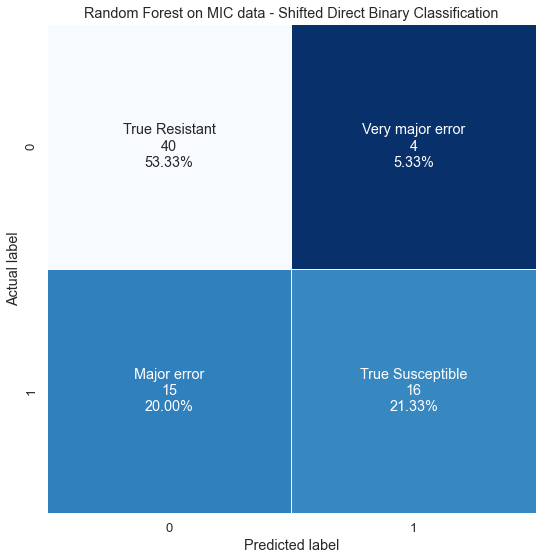

In [25]:
from sklearn import metrics
import seaborn as sns
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Random Forest on MIC data - Shifted Direct Binary Classification');
#plt.savefig('figures/shifted_direct_matrix_MIC_RF.png')